#### Importing the libraries

In [2]:
import collections
import supermarq
import cirq
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from qiskit import *

##### Function defining

In [3]:
def noisy_simulation(circuit: cirq.Circuit, p: float) -> collections.Counter:
    """
    Simulate the given circuit under a depolarizing noise model where every
    gate operation has the chance of depolarizing the qubit with probability p.
    """
    
    shots = 1000
    result = cirq.Simulator().run(circuit.with_noise(cirq.depolarize(p=p)),
                                  repetitions=shots)

    num_measured_qubits = []
    for _, op in circuit.findall_operations(cirq.is_measurement):
        num_measured_qubits.append(len(op.qubits))
    raw_counts = result.multi_measurement_histogram(keys=result.measurements.keys())

    # cirq.Result.multi_measurement_histogram returns a collection.Counter object
    # where the keys are tuples of integers and the values are the shot counts.
    # The integers in the keys indicate the bitstring result of each set of measurement tags.
    counts: Dict[str, float] = collections.defaultdict(float)
    for key, val in raw_counts.items():
        bit_list = []
        for int_tag, num_bits in zip(key, num_measured_qubits):
            bit_list.extend(cirq.value.big_endian_int_to_bits(int_tag, bit_count=num_bits))
        counts["".join([str(b) for b in bit_list])] = val / shots

    return collections.Counter(counts)

In [4]:
#features.py

import cirq
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qiskit
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from typing import Union


def cirq_to_qiskit(circuit: cirq.Circuit) -> qiskit.circuit.QuantumCircuit:
    qasm = cirq.circuits.QasmOutput(circuit, sorted(circuit.all_qubits()))
    return qiskit.circuit.QuantumCircuit().from_qasm_str(str(qasm))


def compute_connectivity(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    N = circ.num_qubits
    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    G = nx.Graph()
    for op in dag.two_qubit_ops():
        q1, q2 = op.qargs
        G.add_edge(q1.index, q2.index)

    degree_sum = sum([G.degree(n) for n in G.nodes])

    return degree_sum / (N * (N - 1))


def compute_liveness(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    N = circ.num_qubits
    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    activity_matrix = np.zeros((N, dag.depth()))

    for i, layer in enumerate(dag.layers()):
        for op in layer["partition"]:
            for qubit in op:
                activity_matrix[qubit.index, i] = 1

    return np.sum(activity_matrix) / (N * dag.depth())


def compute_parallelism(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")
    return max(1 - (circ.depth() / len(dag.gate_nodes())), 0)


def compute_measurement(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    """
    measurement feature = # of layers of mid-circuit measurement / circuit depth

    Input
    -----
    circ : QuantumCircuit
    """
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    reset_moments = 0
    gate_depth = dag.depth() - 1

    for layer in dag.layers():
        reset_present = False
        for op in layer['graph'].op_nodes():
            if op.name == 'reset':
                reset_present += True
        if reset_present:
            reset_moments += 1

    return reset_moments / gate_depth


def compute_entanglement(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")

    return len(dag.two_qubit_ops()) / len(dag.gate_nodes())


def compute_depth(circuit: Union[cirq.Circuit, qiskit.circuit.QuantumCircuit]) -> float:
    if isinstance(circuit, cirq.Circuit):
        circ = cirq_to_qiskit(circuit)
    else:
        circ = circuit

    dag = qiskit.converters.circuit_to_dag(circ)
    dag.remove_all_ops_named("barrier")
    n_ed = 0
    two_q_gates = set([op.name for op in dag.two_qubit_ops()])
    for name in two_q_gates:
        try:
            n_ed += dag.count_ops_longest_path()[name]
        except KeyError:
            continue
    n_e = len(dag.two_qubit_ops())

    if n_ed == 0:
        return 0

    return n_ed / n_e


def radar_factory(num_vars, frame="circle"):
    """
    (https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = "radar"
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location("N")

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=14)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == "circle":
                return Circle((0.5, 0.5), 0.5)
            elif frame == "polygon":
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == "circle":
                return super()._gen_axes_spines()
            elif frame == "polygon":
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self, spine_type="circle", path=Path.unit_regular_polygon(num_vars)
                )
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes)
                return {"polar": spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def plot_benchmark(data, show=True, savefn=None, spoke_labels=None, legend_loc=(0.75, 0.85)):
    """
    Create a radar plot of the given benchmarks.

    Input
    -----
    data : List
        Contains the title, feature data, and labels in the format:
        [title, [labels], [feature vecs: [con, liv, par, mea, ent] ]]
    """
    plt.rcParams["font.family"] = "Times New Roman"

    if spoke_labels is None:
        spoke_labels = ["Connectivity", "Liveness", "Parallelism", "Measurement", "Entanglement"]

    N = len(spoke_labels)
    theta = radar_factory(N, frame="circle")

    fig, ax = plt.subplots(dpi=150, subplot_kw=dict(projection="radar"))
    # fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    title, labels, case_data = data
    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_rgrids([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    # ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
    #             horizontalalignment='center', verticalalignment='center')
    for d, label in zip(case_data, labels):
        ax.plot(theta, d, label=label)
        ax.fill(theta, d, alpha=0.25)
    ax.set_varlabels(spoke_labels)

    ax.legend(loc=legend_loc, labelspacing=0.1, fontsize=11)
    plt.tight_layout()

    if savefn is not None:
        plt.savefig(savefn)

    if show:
        plt.show()

    plt.close()

## Benchmarks

### Hamiltonian Simulation

In [5]:
supermarq.hamiltonian_simulation.HamiltonianSimulation

supermarq.benchmarks.hamiltonian_simulation.HamiltonianSimulation

In [6]:
# Create the benchmark object and circuit
num_qubits = 3
time_step = 1
total_time = 2
hamsim = supermarq.hamiltonian_simulation.HamiltonianSimulation(num_qubits, time_step, total_time)
hamsim_circuit = hamsim.circuit()
print(hamsim_circuit)

0: ───H───Rz(-0.75π)───H───@───────────────@───H───Rz(-0.749π)───H─────────────────────────@───────────────@───────────────────────M───
                           │               │                                               │               │                       │
1: ───H───Rz(-0.75π)───H───X───Rz(-0.5π)───X───@─────────────────@───H───Rz(-0.749π)───H───X───Rz(-0.5π)───X───@───────────────@───M───
                                               │                 │                                             │               │   │
2: ───H───Rz(-0.75π)───H───────────────────────X───Rz(-0.5π)─────X───H───Rz(-0.749π)───H───────────────────────X───Rz(-0.5π)───X───M───


In [7]:
# Perform noisy simulation and evaluate the benchmark score function
hamsim_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(hamsim_circuit, p=error_prob)
    score = hamsim.score(counts)
    hamsim_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Hamiltonian Simulation score = {score:.4f}')

With 0.0% error probability, Hamiltonian Simulation score = 0.9881
With 0.5% error probability, Hamiltonian Simulation score = 0.9504
With 2.0% error probability, Hamiltonian Simulation score = 0.8844


In [9]:
circuit_hs = cirq_to_qiskit(hamsim_circuit)
circuit_hs.draw()
compute_depth(circuit_hs)
compute_entanglement(circuit_hs)
compute_parallelism(circuit_hs)

0.3666666666666667

##### Hamiltonian Simulation Scores Graph plot

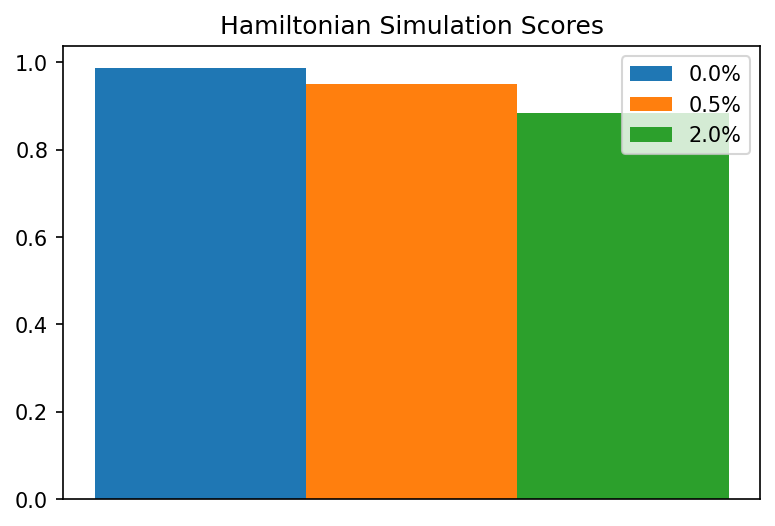

In [8]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(hamsim_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Hamiltonian Simulation Scores')
ax.get_xaxis().set_visible(False)

##### Hamiltonian Simulation Multi-Dimensional radar plot

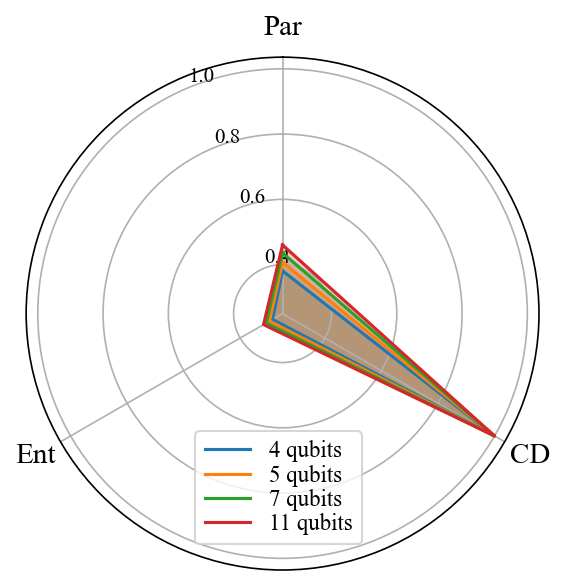

In [10]:
# Hamiltonian Simulation feature plot
title = 'Hamiltonian Simulation'
labels = ['4 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [4, 5, 7, 11]:
    circ = supermarq.hamiltonian_simulation.HamiltonianSimulation(nq).circuit()
    par = compute_parallelism(circ)
    ent = compute_entanglement(circ)
    dep = compute_depth(circ)
    feature_vecs.append([par, ent, dep])
    
spoke_labels = ['Par', 'Ent', 'CD']
plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.33, 0.05))

### Vanilla QAOA

In [11]:
supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy

supermarq.benchmarks.qaoa_vanilla_proxy.QAOAVanillaProxy

In [12]:
# Create the benchmark object and circuit
num_qubits = 3
vanilla_qaoa = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(num_qubits)
vqaoa_circuit = vanilla_qaoa.circuit()
print(vqaoa_circuit)

0: ───H───@─────────────────@─────────────────────────@─────────────────────────@───Rx(0.196π)───M───
          │                 │                         │                         │                │
1: ───H───┼─────────────────┼───@─────────────────@───X────────────Rz(0.804π)───X───Rx(0.196π)───M───
          │                 │   │                 │                                              │
2: ───H───X───Rz(-0.804π)───X───X───Rz(-0.804π)───X───Rx(0.196π)─────────────────────────────────M───


In [13]:
# Perform noisy simulation and evaluate the benchmark score function
vqaoa_scores = []
for error_prob in [0.0, 0.005, 0.02]:
    counts = noisy_simulation(vqaoa_circuit, p=error_prob)
    score = vanilla_qaoa.score(counts)
    vqaoa_scores.append((error_prob, score))
    print(f'With {error_prob*100:.1f}% error probability, Vanilla QAOA score = {score:.4f}')

With 0.0% error probability, Vanilla QAOA score = 1.0000
With 0.5% error probability, Vanilla QAOA score = 0.9460
With 2.0% error probability, Vanilla QAOA score = 0.8180


In [17]:
circuit_vqaoa = cirq_to_qiskit(vqaoa_circuit)

##### Vanilla QAOA Scores Graph plot

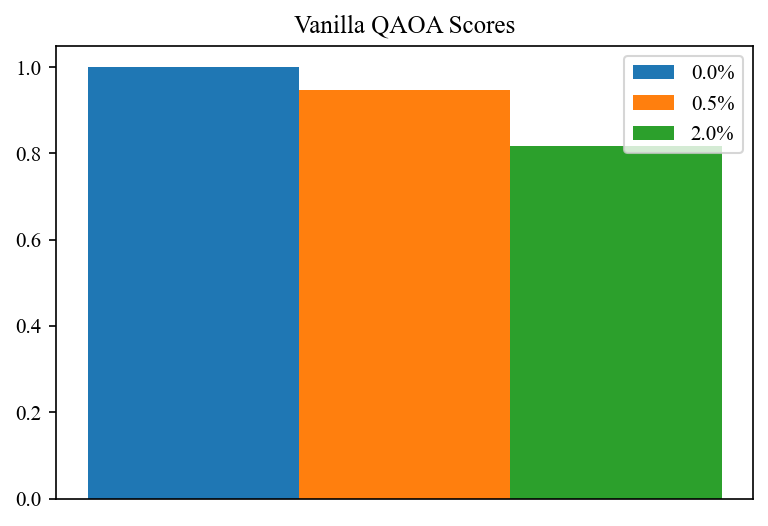

In [18]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
width = 0.1

for i, (error_prob, score) in enumerate(vqaoa_scores):
    
    x = width * i
    ax.bar(x, score, width=width, label=f'{error_prob * 100:.1f}%', align='edge')

ax.legend()
ax.set_title('Vanilla QAOA Scores')
ax.get_xaxis().set_visible(False)

##### Vanilla QAOA Multi-Dimensional radar plot

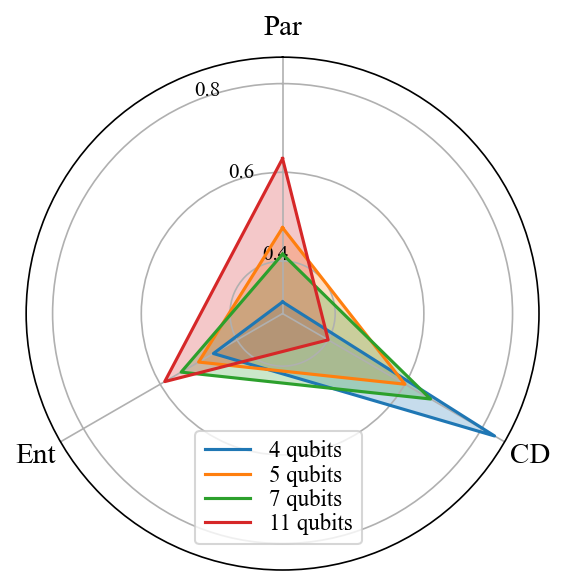

In [16]:
# Vanilla QAOA feature example
title = 'QAOA Vanilla'
labels = ['4 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [4, 5, 7, 11]:
    circ = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(nq).circuit()
    par = compute_parallelism(circ)
    ent = compute_entanglement(circ)
    dep = compute_depth(circ)
    feature_vecs.append([par, ent, dep])
    
spoke_labels = ['Par', 'Ent', 'CD']
plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.33, 0.05))

In [ ]:
# Vanilla QAOA feature example
title = 'QAOA Vanilla'
labels = ['4 qubits', '5 qubits', '7 qubits', '11 qubits']
feature_vecs = []
for nq in [4, 5, 7, 11]:
    circ = supermarq.qaoa_vanilla_proxy.QAOAVanillaProxy(nq).circuit()
    circ1 = supermarq.hamiltonian_simulation.HamiltonianSimulation(nq).circuit()
    par = compute_parallelism(circ)
    par1 = compute_parallelism(circ1)
    ent = compute_entanglement(circ)
    ent1 = compute_entanglement(circ1)
    dep = compute_depth(circ)
    dep1 = compute_depth(circ1)
    feature_vecs.append([par,par1, ent,ent1, dep,dep1])
    
spoke_labels = ['Par','Par1', 'Ent','Ent1', 'CD','CD1']
plot_benchmark([title, labels, feature_vecs], spoke_labels=spoke_labels, legend_loc=(0.33, 0.05))
